For this project, I will be participating in the “I’m Something of a Painter Myself” Kaggle competition. It involves transforming regular photos into Monet-style paintings, creating a model that can generate realistic Monet-inspired artwork.

To do this, I will first rely on GANs—Generative Adversarial Networks. These are special types of neural networks that consist of 2 parts—a generator and a discriminator. The generator creates above-mentioned Monet-style art and the discriminator evaluates whether the art is genuine or generated. The goal is for the generator to become good enough to fool the discriminator.

The project will be available at my GitHub: https://github.com/giosofteng/isoapm

Let us start by importing all necessary data and doing some preprocessing:

In [1]:
import os
import tensorflow as tf

# read and process image
def get_image(path):
    # read JPEG
    image = tf.io.read_file(path)
    # convert it to 3-channel tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # make it 256x256px
    image = tf.image.resize(image, (256, 256))
    # normalize pixel values to [-1, 1] range--improves performance
    return (image - 127.5) / 127.5

# load Monet JPEGs
images_monet = tf.data.Dataset.list_files(os.path.join('data/monet_jpg', '*.jpg'))
# preprocess them (in parallel for better performance)
images_monet = images_monet.map(get_image, num_parallel_calls=tf.data.AUTOTUNE)
# batch them as 16-item groups (prefetch for better performance)
images_monet = images_monet.batch(16).prefetch(tf.data.AUTOTUNE)
# do same for photo JPEGs
images_photo = tf.data.Dataset.list_files(os.path.join('data/photo_jpg', '*.jpg'))
images_photo = images_photo.map(get_image, num_parallel_calls=tf.data.AUTOTUNE)
images_photo = images_photo.batch(16).prefetch(tf.data.AUTOTUNE)

Next, let us display some basic info about the loaded data—make sure that everything’s in order:

In [4]:
# display Monet batches count
print(f'Number of Monet batches: {
    tf.data.experimental.cardinality(images_monet).numpy()}')
# display basic info for 1st Monet batch
for batch in images_monet.take(1):
    # display batch size
    print(f'Monet batch size: {batch.shape[0]}')
    # display data type
    print(f'Data type: {batch.dtype}')
    # display image dimensions
    print(f'Image dimensions (height, weight, colors): {batch.shape[1:]}')
    # display pixel value range
    print(f'Pixel values range (min, max): ({
        tf.reduce_min(batch).numpy()}, {tf.reduce_max(batch).numpy()})\n')

# do same for photo batches
print(f'Number of photo batches: {
    tf.data.experimental.cardinality(images_photo).numpy()}')
for batch in images_photo.take(1):
    print(f'Photo batch size: {batch.shape[0]}')
    print(f'Data type: {batch.dtype}')
    print(f'Image dimensions (height, weight, colors): {batch.shape[1:]}')
    print(f'Pixel values range (min, max): ({
        tf.reduce_min(batch).numpy()}, {tf.reduce_max(batch).numpy()})')

Number of Monet batches: 19
Monet batch size: 16
Data type: <dtype: 'float32'>
Image dimensions (height, weight, colors): (256, 256, 3)
Pixel values range (min, max): (-1.0, 1.0)

Number of photo batches: 440
Photo batch size: 16
Data type: <dtype: 'float32'>
Image dimensions (height, weight, colors): (256, 256, 3)
Pixel values range (min, max): (-1.0, 1.0)


Everything seems to be in order! Let us now conduct some basic EDA on our data.

Let us start by displaying 9 images from Monet and photo datasets:

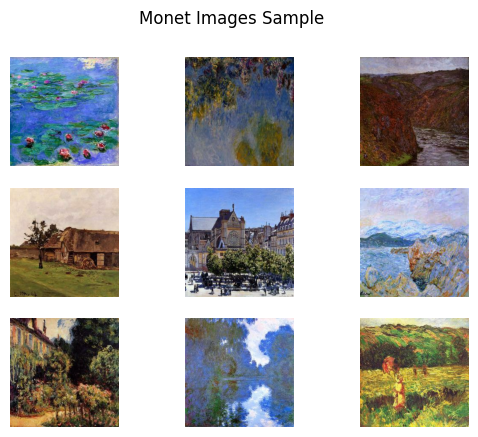

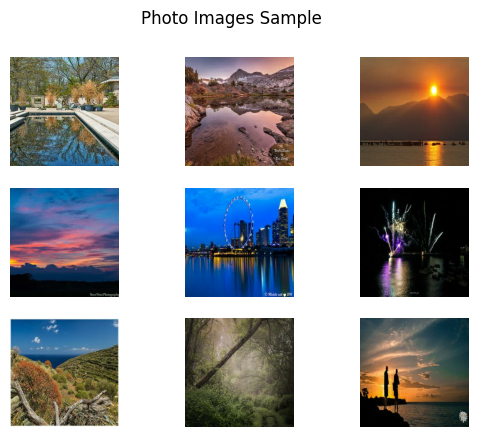

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# display 9 images from a batch of 16
def display_images(batch, title):
    for i in range(9):
        subplot = plt.subplot(3, 3, i + 1)
        # convert pixel data back to [0, 255] range
        plt.imshow((batch[i].numpy() * 127.5 + 127.5).astype(np.uint8))
        plt.axis("off")
    plt.suptitle(f'{title} Images Sample')
    plt.show()

# display 9 Monet images
for batch in images_monet.take(1):
    display_images(batch, 'Monet')
# display 9 photo images
for batch in images_photo.take(1):
    display_images(batch, 'Photo')

Let us also display histograms for pixel values for 1 batch from each dataset:

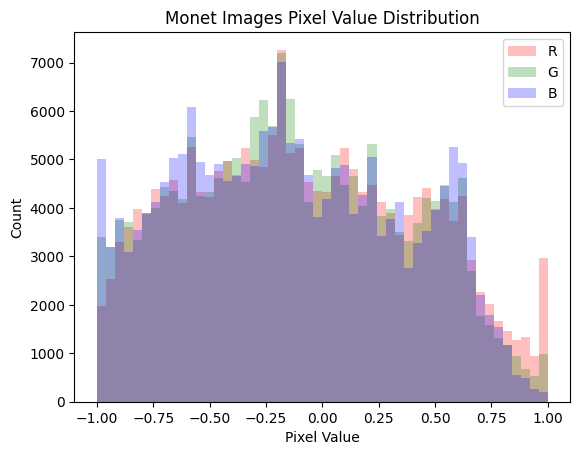

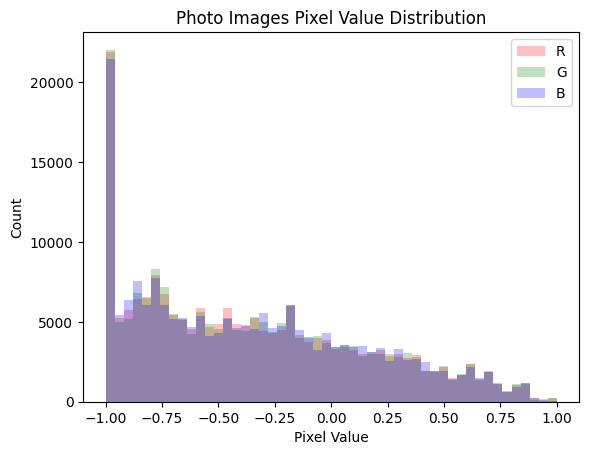

In [7]:
# plot pixel value histogram for a batch
def display_pixel_values(batch, title):
    # flatten each image's pixel values for each channel
    red = []
    green = []
    blue = []
    for image in batch:
        red.extend(batch[:, :, 0].numpy().flatten())
        green.extend(batch[:, :, 1].numpy().flatten())
        blue.extend(batch[:, :, 2].numpy().flatten())
    plt.hist(red, bins=50, color='red', alpha=0.25, label='R')
    plt.hist(green, bins=50, color='green', alpha=0.25, label='G')
    plt.hist(blue, bins=50, color='blue', alpha=0.25, label='B')
    plt.title(f'{title} Images Pixel Value Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

for batch in images_monet.take(1):
    display_pixel_values(batch, 'Monet')
for batch in images_photo.take(1):
    display_pixel_values(batch, 'Photo')

Lastly, let us also print out mean and standard deviation for each color channel for 1 batch from each dataset:

In [8]:
# display mean and std dev for each color channel in a batch
def display_mean_std(batch, title):
    mean_red = []
    mean_green = []
    mean_blue = []
    std_red = []
    std_green = []
    std_blue = []
    for image in batch:
        mean_red.append(tf.reduce_mean(image[:, :, 0]))
        mean_green.append(tf.reduce_mean(image[:, :, 1]))
        mean_blue.append(tf.reduce_mean(image[:, :, 2]))
        std_red.append(tf.math.reduce_std(image[:, :, 0]))
        std_green.append(tf.math.reduce_std(image[:, :, 1]))
        std_blue.append(tf.math.reduce_std(image[:, :, 2]))
    print(f'{title} Images:')
    print(f'\tMean (R, G, B): ({
        np.mean(mean_red):.2f}, {np.mean(mean_green):.2f}, {np.mean(mean_blue):.2f})')
    print(f'\tStd Dev (R, G, B): ({
        np.mean(std_red):.2f}, {np.mean(std_green):.2f}, {np.mean(std_blue):.2f})')

for batch in images_monet.take(1):
    display_mean_std(batch, 'Monet')
print()
for batch in images_photo.take(1):
    display_mean_std(batch, 'Photo')

Monet Images:
	Mean (R, G, B): (0.08, 0.08, 0.01)
	Std Dev (R, G, B): (0.36, 0.35, 0.38)

Photo Images:
	Mean (R, G, B): (-0.21, -0.17, -0.29)
	Std Dev (R, G, B): (0.39, 0.34, 0.43)


Let us now move on to the model-building.

A good fit for this kind of “style transfer” problem is a variant of GAN called CycleGAN. It will allow us to transform images between our two domains—photo and Monet. As previously stated, we will be implementing a generator and a discriminator. The generator will use a variety of downsampling, residual, and upsampling layers to capture key image details. The discriminator will, in turn, contain convolutional layers of increasing sizes that will break down the images, helping it focus on lower-level patterns to discern real and fake images.

In [3]:
from tensorflow.keras import layers

def get_generator():
    # input layer for 256x256px RGB images
    inputs = layers.Input(shape=(256, 256, 3))
    # downsampling layers:
    # 1st convolutional layer with Leaky ReLU activation
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    # 2nd convolutional layer with Leaky ReLU activation
    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    # batch normalization for added stability
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    # 6 residual layers:
    for _ in range(6):
        # 1st convolutional layer with Leaky ReLU activation
        r = layers.Conv2D(128, kernel_size=3, padding='same')(x)
        # batch normalization for added stability
        r = layers.BatchNormalization()(r)
        r = layers.ReLU()(r)
        # 2nd convolutional layer
        r = layers.Conv2D(128, kernel_size=3, padding='same')(r)
        # batch normalization for added stability
        r = layers.BatchNormalization()(r)
        # skip connection to preserve input features
        x = layers.add([x, r])
    # upsampling layers:
    # 1st transposed convolutional layer with ReLU activation
    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    # batch normalization for added stability
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # 2nd transposed convolutional layer with ReLU activation
    x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    # batch normalization for added stability
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # output layer with tanh activation
    outputs = layers.Conv2D(3, kernel_size=7, padding='same', activation='tanh')(x)
    # generator model
    return tf.keras.Model(inputs, outputs)

def get_discriminator():
    # input layer for 256x256px RGB images
    inputs = layers.Input(shape=(256, 256, 3))
    # 4 convolutional layers with Leaky ReLU activations and batch normalization
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(512, kernel_size=4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    # output layer
    outputs = layers.Conv2D(1, kernel_size=4, padding='same')(x)
    # discriminator model
    return tf.keras.Model(inputs, outputs)

# get generators and discriminators:
# transform photos to Monet-style art
generator_g = get_generator()
# vice-versa
generator_f = get_generator()
# discriminate Monet-style art
discriminator_x = get_discriminator()
# discriminate photos
discriminator_y = get_discriminator()

# display model summaries
generator_g.summary()
generator_f.summary()
discriminator_x.summary()
discriminator_y.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 128, 128,  │      3,136 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_12      │ (None, 128, 128,  │          0 │ conv2d_40[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 64, 64,    │    131,200 │ leaky_re_lu_12[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_13      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 64, 64,    │    147,584 │ leaky_re_lu_13[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 64, 64,    │    147,584 │ re_lu_16[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 64, 64,    │          0 │ leaky_re_lu_13[0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 64, 64,    │    147,584 │ add_12[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_44[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 64, 64,    │    147,584 │ re_lu_17[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_45[0][0] 

 Total params: 2,315,587 (8.83 MB)

 Trainable params: 2,311,875 (8.82 MB)

 Non-trainable params: 3,712 (14.50 KB)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 128, 128,  │      3,136 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_14      │ (None, 128, 128,  │          0 │ conv2d_55[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 64, 64,    │    131,200 │ leaky_re_lu_14[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_15      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 64, 64,    │    147,584 │ leaky_re_lu_15[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_24 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 64, 64,    │    147,584 │ re_lu_24[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 64, 64,    │          0 │ leaky_re_lu_15[0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 64, 64,    │    147,584 │ add_18[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_25 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 64, 64,    │    147,584 │ re_lu_25[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_60[0][0] 

 Total params: 2,315,587 (8.83 MB)

 Trainable params: 2,311,875 (8.82 MB)

 Non-trainable params: 3,712 (14.50 KB)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 16, 16, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 16, 16, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,768,321 (10.56 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 16, 16, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 16, 16, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,768,321 (10.56 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

Next, let us train this model with out image data:

In [15]:
# generator loss function
def loss_gen(disc_gen_out):
    # discriminator should output values close to 1 for generated images
    return tf.keras.losses.MeanSquaredError()(tf.ones_like(disc_gen_out), disc_gen_out)

# discriminator loss function
def loss_disc(disc_real_out, disc_gen_out):
    # discriminator loss for real images--should output values close to 1
    loss_real = tf.keras.losses.MeanSquaredError()(tf.ones_like(disc_real_out), disc_real_out)
    # discriminator loss for generated images--should output values close to 0
    loss_gen = tf.keras.losses.MeanSquaredError()(tf.zeros_like(disc_gen_out), disc_gen_out)
    # total discriminator loss
    return loss_real + loss_gen

# cycle consistency loss--make sure generated images can revert to originals
def loss_cycle_cons(image_real, image_cycle):
    # penalize big difference
    return tf.reduce_mean(tf.abs(image_real - image_cycle)) * 10

# optimizers for generators and discriminators
opt_gen_g = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
opt_gen_f = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
opt_disc_x = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
opt_disc_y = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

# training function with decorator for better performance
@tf.function
def tran(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # photo - Monet - photo cycle:
        # generate Monet image from photo
        fake_y = generator_g(real_x, training=True)
        # cycle back to photo
        cycle_x = generator_f(fake_y, training=True)
        # Monet - photo - Monet cycle:
        # generate photo from Monet image
        fake_x = generator_f(real_y, training=True)
        # cycle back to Monet
        cycled_y = generator_g(fake_x, training=True)
        
        # discriminator predictions:
        # for real photos
        disc_real_x = discriminator_x(real_x, training=True)
        # for generated photos
        disc_fake_x = discriminator_x(fake_x, training=True)
        # for real Monet images
        disc_real_y = discriminator_y(real_y, training=True)
        # for generated Monet images
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # generator losses:
        # cycle consistency loss
        loss_cycle = loss_cycle_cons(real_x, cycle_x) + loss_cycle_cons(real_y, cycled_y)
        # photo - Monet generator loss
        loss_gen_g = loss_gen(disc_fake_y) + loss_cycle
        # Monet -> photo generator loss
        loss_gen_f = loss_gen(disc_fake_x) + loss_cycle
        # discriminator losses:
        # photo discriminator loss
        loss_disc_x = loss_disc(disc_real_x, disc_fake_x)
        # Monet discriminator loss
        loss_disc_y = loss_disc(disc_real_y, disc_fake_y)
    # gradients:
    # for photo - Monet generator
    grad_gen_g = tape.gradient(loss_gen_g, generator_g.trainable_variables)
    # for Monet - photo generator
    grad_gen_f = tape.gradient(loss_gen_f, generator_f.trainable_variables)
    # for photo discriminator
    grad_disc_x = tape.gradient(loss_disc_x, discriminator_x.trainable_variables)
    # for Monet discriminator
    grad_disc_y = tape.gradient(loss_disc_y, discriminator_y.trainable_variables)
    # update model weights
    opt_gen_g.apply_gradients(zip(grad_gen_g, generator_g.trainable_variables))
    opt_gen_f.apply_gradients(zip(grad_gen_f, generator_f.trainable_variables))
    opt_disc_x.apply_gradients(zip(grad_disc_x, discriminator_x.trainable_variables))
    opt_disc_y.apply_gradients(zip(grad_disc_y, discriminator_y.trainable_variables))
    return {
        "gen_g_loss": loss_gen_g,
        "gen_f_loss": loss_gen_f,
        "disc_x_loss": loss_disc_x,
        "disc_y_loss": loss_disc_y
    }

for epoch in range(10):
    for real_x, real_y in tf.data.Dataset.zip((images_photo, images_monet)):
        losses = tran(real_x, real_y)
    print(f'Epoch {epoch + 1}, Losses: {losses}')

Epoch 1, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2420833110809326>, 'gen_f_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1499996185302734>, 'disc_x_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.43786758184432983>, 'disc_y_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.3306267559528351>}
Epoch 2, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.462501049041748>, 'gen_f_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.651071071624756>, 'disc_x_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.0748332738876343>, 'disc_y_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.533237874507904>}
Epoch 3, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.282771110534668>, 'gen_f_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.275788307189941>, 'disc_x_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.38417524099349976>, 'disc_y_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.36621910333633423>}
Epoch 

Having trained our model, let us visualize some generated images:

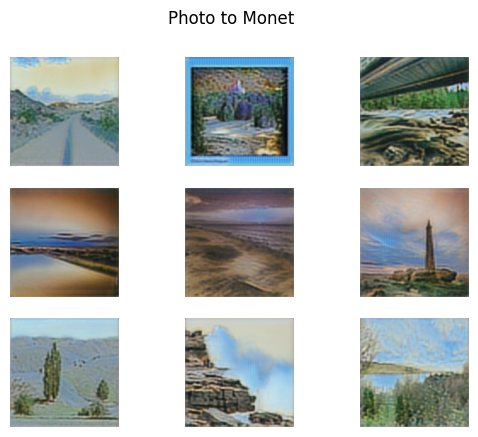

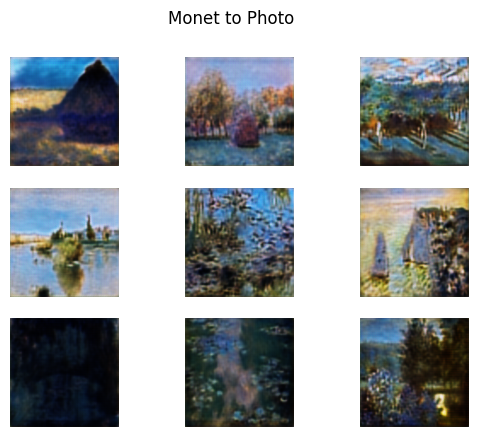

In [23]:
def display_gen_images(generator, data, title):
    fig, axs = plt.subplots(3, 3)
    fig.suptitle(title)
    for i, image_real in enumerate(data.take(9)):
        # generate image using trained generator
        image_gen = generator(image_real, training=False)
        image_gen = (image_gen + 1) / 2
        axs[i // 3, i % 3].imshow(image_gen[0].numpy())
        axs[i // 3, i % 3].axis('off')
    plt.show()

# display photo - Monet generated images
display_gen_images(generator_g, images_photo, title='Photo to Monet')
# display Monet - photo generated images
display_gen_images(generator_f, images_monet, title='Monet to Photo')

Not too bad for only 10 epochs! Let us now introduce a slightly differet way of tackling this problem, using transfer learning with VGG19 as the feature extractor:

In [10]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

# import ImageNet-trained VGG19 model without top layer
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
# select conv layers from each block--best for extracting style features
layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']
# init model
output = [vgg.get_layer(layer).output for layer in layers]
vgg19 = Model(inputs=vgg.input, outputs=output)
# freeze weights while training
vgg19.trainable = False

# calculate style loss with VGG19 features
def get_style_loss(img_gen, img_style):
    # ensure same batch size
    min_batch_size = tf.minimum(tf.shape(img_gen)[0], tf.shape(img_style)[0])
    img_gen = tf.slice(img_gen, [0, 0, 0, 0], [min_batch_size, -1, -1, -1])
    img_style = tf.slice(img_style, [0, 0, 0, 0], [min_batch_size, -1, -1, -1])
    # get style features
    feat_gen = vgg19(img_gen)
    feat_style = vgg19(img_style)
    # get style loss
    style_loss = 0
    for gen, style in zip(feat_gen, feat_style):
        style_loss += tf.reduce_mean(tf.square(gen - style))
    # normalize style loss
    return style_loss / len(feat_gen)

# new train function with VGG19 style loss
@tf.function
def tran(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        cycle_x = generator_f(fake_y, training=True)
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        disc_real_x = discriminator_x(real_x, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        loss_cycle = loss_cycle_cons(real_x, cycle_x) + loss_cycle_cons(real_y, cycled_y)
        loss_gen_g = loss_gen(disc_fake_y) + loss_cycle
        loss_gen_f = loss_gen(disc_fake_x) + loss_cycle
        # VGG19 style loss for Monet generator
        style_loss = get_style_loss(fake_y, real_y)
        # add it to the generator's total loss
        loss_gen_g += style_loss * 10
        loss_disc_x = loss_disc(disc_real_x, disc_fake_x)
        loss_disc_y = loss_disc(disc_real_y, disc_fake_y)
    grad_gen_g = tape.gradient(loss_gen_g, generator_g.trainable_variables)
    grad_gen_f = tape.gradient(loss_gen_f, generator_f.trainable_variables)
    grad_disc_x = tape.gradient(loss_disc_x, discriminator_x.trainable_variables)
    grad_disc_y = tape.gradient(loss_disc_y, discriminator_y.trainable_variables)
    opt_gen_g.apply_gradients(zip(grad_gen_g, generator_g.trainable_variables))
    opt_gen_f.apply_gradients(zip(grad_gen_f, generator_f.trainable_variables))
    opt_disc_x.apply_gradients(zip(grad_disc_x, discriminator_x.trainable_variables))
    opt_disc_y.apply_gradients(zip(grad_disc_y, discriminator_y.trainable_variables))
    return {
        "gen_g_loss": loss_gen_g,
        "gen_f_loss": loss_gen_f,
        "disc_x_loss": loss_disc_x,
        "disc_y_loss": loss_disc_y,
        "style_loss": style_loss
    }

for epoch in range(10):
    for real_x, real_y in tf.data.Dataset.zip((images_photo, images_monet)):
        losses = tran(real_x, real_y)
    print(f'Epoch {epoch + 1}, Losses: {losses}')

2024-11-07 20:53:33.139422: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=508.2376403808594>, 'gen_f_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.5579400062561035>, 'disc_x_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.3823184370994568>, 'disc_y_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.18954487144947052>, 'style_loss': <tf.Tensor: shape=(), dtype=float32, numpy=50.12920379638672>}
Epoch 2, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=473.15777587890625>, 'gen_f_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.5742692947387695>, 'disc_x_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.40877628326416016>, 'disc_y_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.11677759140729904>, 'style_loss': <tf.Tensor: shape=(), dtype=float32, numpy=46.60639953613281>}


2024-11-07 21:07:21.278463: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=434.9632263183594>, 'gen_f_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.299099922180176>, 'disc_x_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.4771376848220825>, 'disc_y_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.1398668885231018>, 'style_loss': <tf.Tensor: shape=(), dtype=float32, numpy=42.80426025390625>}
Epoch 4, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=447.9906005859375>, 'gen_f_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.53790807723999>, 'disc_x_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.4641692042350769>, 'disc_y_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.09426884353160858>, 'style_loss': <tf.Tensor: shape=(), dtype=float32, numpy=44.07646179199219>}
Epoch 5, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=460.5611267089844>, 'gen_f_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.065704822540283>, 'disc_x_loss':

2024-11-07 21:34:47.596914: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=400.7905578613281>, 'gen_f_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.1631059646606445>, 'disc_x_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.42264413833618164>, 'disc_y_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.0704825222492218>, 'style_loss': <tf.Tensor: shape=(), dtype=float32, numpy=39.39521026611328>}
Epoch 8, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=388.8531494140625>, 'gen_f_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.810421466827393>, 'disc_x_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.4243374466896057>, 'disc_y_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.11243157088756561>, 'style_loss': <tf.Tensor: shape=(), dtype=float32, numpy=38.14204406738281>}
Epoch 9, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=410.835693359375>, 'gen_f_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.31760835647583>, 'disc_x_loss'

Let us again visualize some generated images:

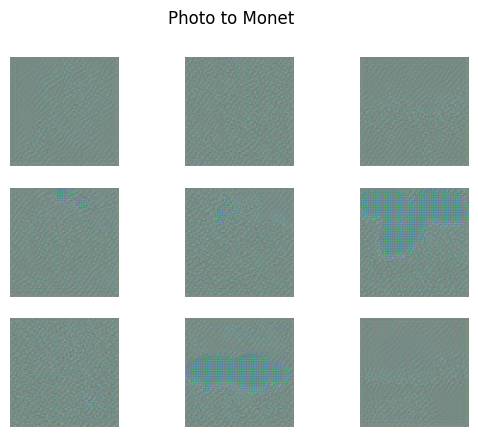

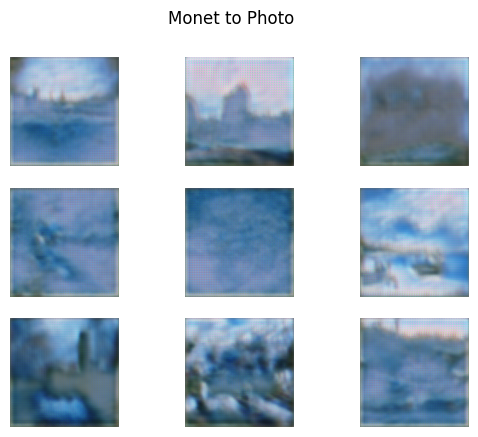

In [14]:
def display_gen_images(generator, data, title):
    fig, axs = plt.subplots(3, 3)
    fig.suptitle(title)
    for i, image_real in enumerate(data.take(9)):
        image_gen = generator(image_real, training=False)
        image_gen = (image_gen + 1) / 2
        axs[i // 3, i % 3].imshow(image_gen[0].numpy())
        axs[i // 3, i % 3].axis('off')
    plt.show()

display_gen_images(generator_g, images_photo, title='Photo to Monet')
display_gen_images(generator_f, images_monet, title='Monet to Photo')

Curiously, we seem to have gotten worse results with transfer learning! This might have to do with the limited number of epochs.

So, to summarize, for our attempt, we tried to leverage CycleGANs to create Monet-style art. To do this, we started by loading all JPEGs in batches, doing some pre-processing to help out our models. Since the data did not require cleaning, we then moved on to EDA and visualized the sample data, as well as its pixel value distributions and mean and standard deviation for its color channels. We then built and trained a model that showed decent (though far from perfect) results after training for 10 epochs. To improve our results, we tried to leverage transfer learning using a pre-trained VGG19 model as feature extractor. This, however, failed to yield any improvements. Further steps would include trying to figure out what went wrong with the transfer learning-enabled model and to train the model for more epochs on a more performant machine!